## Deconvolving single-cell family size distribution into chimeric and real components

In [ ]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import time
import matplotlib.pylab as plt
from commons import *
from sc_fingerprint import SingleCellFingerprint, SingleCellFingerprintDataStore
from sc_fsd_codec import GeneralNegativeBinomialMixtureFamilySizeDistributionCodec
from sc_fsd_mixture_model import SingleCellFamilySizeModel

import pyro
from pyro import poutine
from pyro.infer import Trace_ELBO, SVI
from pyro.optim import Adam
from pyro_extras import checkpoint_model, load_latest_checkpoint
from pyro_extras import ZeroInflatedNegativeBinomial

import torch

import scipy.sparse as sp
import logging
from collections import Counter
import pickle 
from scipy.signal import savgol_filter

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

## Inputs, outputs, and model hyperparameters

In [ ]:
# dataset_name = 'pbmc4k_ss_rate_0.25'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_ss_rate_0.25_sc_fingerprint.pkl'

dataset_name = 'pbmc4k'
sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_sc_fingerprint.pkl'

zinb_fitter_kwargs = {
    'lr': 0.5,
    'max_iters': 10_000,
    'p_zero_l1_reg': 0.001,
    'outlier_stringency': 5.0,
    'max_zinb_p_zero': 0.9995,
    'min_zinb_p_zero': 0.0005,
    'min_nb_phi': 0.01,
    'max_nb_phi': 0.95
}


# generate a gene expression ladder for testing the full dynamic range
all_genes_default_filter = np.load(
    '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_1.0__default_gene_filters__zinb/gene_indices.npy')
gene_expr_ladder_idx_list = all_genes_default_filter[::10]

# Instantiate the fingerprint datastore
sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
sc_fingerprint_datastore = SingleCellFingerprintDataStore(
    sc_fingerprint,
    gene_idx_list=gene_expr_ladder_idx_list,
    n_gene_groups=10,
    zinb_fitter_kwargs=zinb_fitter_kwargs,
    max_estimated_chimera_family_size=0)


# # load fingerprint and instantiate the data-store
# sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
# sc_fingerprint = sc_fingerprint.filter_genes()

# # Instantiate the fingerprint datastore
# sc_fingerprint_datastore = SingleCellFingerprintDataStore(
#     sc_fingerprint,
#     top_k_genes=sc_fingerprint.num_genes,
#     n_gene_groups=100,
#     zinb_fitter_kwargs=zinb_fitter_kwargs,
#     max_estimated_chimera_family_size=0)


# sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
# sc_fingerprint_datastore = SingleCellFingerprintDataStore(
#     sc_fingerprint, top_k_genes=50, n_gene_groups=10, zinb_fitter_kwargs=zinb_fitter_kwargs)

# # generate top 200 genes
# all_genes_default_filter = np.load(
#     '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_1.0__default_gene_filters__zinb/gene_indices.npy')
# gene_expr_top_200_idx_list = all_genes_default_filter[:200]

# # Instantiate the fingerprint datastore
# sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path)
# sc_fingerprint_datastore = SingleCellFingerprintDataStore(
#     sc_fingerprint,
#     gene_idx_list=gene_expr_top_200_idx_list,
#     n_gene_groups=10,
#     zinb_fitter_kwargs=zinb_fitter_kwargs,
#     max_estimated_chimera_family_size=0)

## Model, training, and regularization configuration

In [ ]:
n_iters = 100_000

mb_genes_per_gene_group = 20
mb_expressing_cells_per_gene = 20
mb_silent_cells_per_gene = 1

init_params_dict = {
    'chimera.alpha_c': 0.0,
    'chimera.beta_c': 0.5,
    'fsd.gmm_num_components': 5,
    'fsd.gmm_dirichlet_concentration': 1.0,
    'fsd.gmm_min_weight_per_component': 1e-3,
    'fsd.gmm_init_xi_scale': 1.5,
    'fsd.gmm_min_xi_scale': 0.1,
    'fsd.gmm_init_components_perplexity': 0.5,
    'fsd.enable_fsd_w_dirichlet_reg': True,
    'fsd.enable_gmm_scale_optimization': True,
    'fsd.w_lo_dirichlet_reg_strength': 1.0,
    'fsd.w_hi_dirichlet_reg_strength': 1.0,
    'fsd.w_lo_dirichlet_concentration': 0.001,
    'fsd.w_hi_dirichlet_concentration': 0.001,
    'fsd.xi_posterior_min_scale': 0.0,
    'chimera.enable_hyperparameter_optimization': False,
    'model.fingerprint_log_likelihood_n_particles': 10
}


fsd_init_params_dict = {
    'fsd_init.min_mu_lo': 0.02,
    'fsd_init.min_mu_hi': 0.2,
    'fsd_init.max_phi_lo': 1.5,
    'fsd_init.max_phi_hi': 0.5,
    'fsd_init.mu_decay': 0.75,
    'fsd_init.w_decay': 0.2,
    'fsd_init.mu_lo_to_mu_hi_ratio': 0.05}


model_constraint_params_dict = {
    # phi_lo is softly pinned to 1.0 (to decrease the parameter complexity of chimeras)
    'phi_lo_comps': {
        'pin_value': 1.0,
        'pin_strength': 1e8,
        'pin_exponent': 2},
    
    # no component of p_hi is allowed to be too over-dispersed
    'phi_hi_comps': {
        'upper_bound_value': 0.5,
        'upper_bound_width': 0.1,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},

    # no component of p_lo can have too small or too large of a mean family size compared to the empirical mean
    'mu_lo_comps_to_mu_empirical_ratio': {
        'lower_bound_value': 0.001,
        'lower_bound_width': 0.001,
        'lower_bound_strength': 1e4,
        'lower_bound_exponent': 2,
        'upper_bound_value': 0.1,
        'upper_bound_width': 0.01,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},
    
    # no component of p_hi can have too small or too large of a mean family size compared to the empirical mean
    'mu_hi_comps_to_mu_empirical_ratio': {
        'lower_bound_value': 0.3,
        'lower_bound_width': 0.1,
        'lower_bound_strength': 1e4,
        'lower_bound_exponent': 2,
        'upper_bound_value': 5.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},
    
    # the ratio of observed chimeric to real molecules can not exceed a certain value
    'p_obs_lo_to_p_obs_hi_ratio': {
        'upper_bound_value': 0.2,
        'upper_bound_width': 0.05,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},

    # the component weights of p_hi cannot reach below a certain value (for stability of Dirichlet prior)
    'w_hi_comps': {
        'lower_bound_value': 0.01,
        'lower_bound_width': 0.005,
        'lower_bound_strength': 1e6,
        'lower_bound_exponent': 1},
    
    # the component weights of p_hi cannot reach below a certain value (for stability of Dirichlet prior)
    'w_lo_comps': {
        'lower_bound_value': 0.01,
        'lower_bound_width': 0.005,
        'lower_bound_strength': 1e6,
        'lower_bound_exponent': 1},

    # make sure that phi_e_hi is not too small or too large (to prevent over/under-flows)
    'phi_e_hi_batch': {
        'lower_bound_value': 0.001,
        'lower_bound_width': 0.001,
        'lower_bound_strength': 1e4,
        'lower_bound_exponent': 2,
        'upper_bound_value': 5.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},

    # make sure that logit_p_zero_e_hi_batch is not too small or too large (to prevent over/under-flows)
    'logit_p_zero_e_hi_batch': {
        'lower_bound_value': -8.0,
        'lower_bound_width': 1.0,
        'lower_bound_strength': 1e4,
        'lower_bound_exponent': 2,
        'upper_bound_value': 8.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': 1e4,
        'upper_bound_exponent': 2},
}


def adam_args(module_name, param_name):
    slow_lr = 1e-3
    slow_params = {
        'alpha_c', 'beta_c',
        'mu_e_lo', 'phi_e_lo',
        'mu_e_hi', 'phi_e_hi', 'logit_p_zero_e_hi',
        'fsd_xi_prior_weights_map'}
    
    fast_lr = 2e-3
    fast_params = {}
    
    default_lr = 2e-3
    
    if param_name in slow_params:
        lr = slow_lr
    elif param_name in fast_params:
        lr = fast_lr
    else:
        lr = default_lr
    
    return {"lr": lr, "eps": 1e-4, 'betas': (0.95, 0.999)}

In [ ]:
root = '/home/jupyter/data/10x/out'
# suffix = "default_gene_filters__new_model_test"
# suffix = "expr_small_ladder_test__poisson_proper"
suffix = "expr_ladder_test__exact_no_sum"
# suffix = "default_gene_filters__rc_poisson_proper"
# suffix = "top_200_genes__poisson_e_obs__zinb_heavy_reg_gmm__new"
# suffix = "top_50_genes__zinb_heavy_reg_gmm"

if init_params_dict['chimera.enable_hyperparameter_optimization']:
    output_path = os.path.join(
        root,
        f"{dataset_name}_" +
        f"_variable_chimera_hyperparameters_" +
        f"_{suffix}")
else:
    output_path = os.path.join(
        root,
        f"{dataset_name}_" +
        f"_alpha_{init_params_dict['chimera.alpha_c']:.1f}_" +
        f"_beta_{init_params_dict['chimera.beta_c']:.1f}_" +
        f"_{suffix}")

checkpoint_path = os.path.join(output_path, "checkpoints")

try:
    print(output_path)
    print(checkpoint_path)
    os.mkdir(output_path)
    os.mkdir(checkpoint_path)
except:
    pass

e_lo_map_output_path = os.path.join(output_path, "e_lo_map.npy")
e_lo_mean_output_path = os.path.join(output_path, "e_lo_mean.npy")
e_lo_var_output_path = os.path.join(output_path, "e_lo_var.npy")
e_lo_ci_lower_output_path = os.path.join(output_path, "e_lo_ci_lower.npy")
e_lo_ci_upper_output_path = os.path.join(output_path, "e_lo_ci_upper.npy")

e_hi_map_output_path = os.path.join(output_path, "e_hi_map.npy")
e_hi_mean_output_path = os.path.join(output_path, "e_hi_mean.npy")
e_hi_var_output_path = os.path.join(output_path, "e_hi_var.npy")
e_hi_ci_lower_output_path = os.path.join(output_path, "e_hi_ci_lower.npy")
e_hi_ci_upper_output_path = os.path.join(output_path, "e_hi_ci_upper.npy")

gene_indices_output_path = os.path.join(output_path, "gene_indices.npy")
cell_barcodes_output_path = os.path.join(output_path, "cell_barcodes.npy")

## Training schedule, optimizer, loss, and regularization

In [ ]:
pyro.clear_param_store()

device = torch.device('cuda')
dtype = torch.float

fsd_codec = GeneralNegativeBinomialMixtureFamilySizeDistributionCodec(
    sc_fingerprint_datastore=sc_fingerprint_datastore,
    n_fsd_lo_comps=1,
    n_fsd_hi_comps=2,
    fsd_init_params_dict=fsd_init_params_dict)

model = SingleCellFamilySizeModel(
    init_params_dict=init_params_dict,
    model_constraint_params_dict=model_constraint_params_dict,
    sc_fingerprint_datastore=sc_fingerprint_datastore,
    fsd_codec=fsd_codec,
    guide_type='map')

optim = Adam(adam_args)
loss = Trace_ELBO()
svi = SVI(model.model, model.guide, optim, loss=loss)

In [ ]:
# mb_data = sc_fingerprint_datastore.generate_stratified_sample_torch(1, 10, 15)
# trace = poutine.trace(model.model).get_trace(mb_data)
# print(trace.format_shapes())

In [ ]:
loss_hist = []
# load_latest_checkpoint(checkpoint_path)

# other_output_path = '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_0.5__default_gene_filters__rc'
other_output_path = None
if other_output_path is None:
    model_output_path = os.path.join(output_path, f"{dataset_name}_{sc_fingerprint_datastore.n_genes}_genes_marginalized.pyro")
else:
    model_output_path = os.path.join(other_output_path, f"{dataset_name}_{sc_fingerprint_datastore.n_genes}_genes_marginalized.pyro")
pyro.get_param_store().load(model_output_path)

# with torch.no_grad():
#     # adapt model parameters to downsampled dataset
#     fsd_params_dict = fsd_codec.decode(pyro.param("fsd_xi_posterior_loc"))

#     kappa = 0.25
#     downsampled_fsd_params_dict = dict()
#     downsampled_fsd_params_dict['phi_lo'] = fsd_params_dict['phi_lo']
#     downsampled_fsd_params_dict['phi_hi'] = fsd_params_dict['phi_hi']
#     downsampled_fsd_params_dict['w_lo'] = fsd_params_dict['w_lo']
#     downsampled_fsd_params_dict['w_hi'] = fsd_params_dict['w_hi']
#     downsampled_fsd_params_dict['mu_lo'] = kappa * fsd_params_dict['mu_lo']
#     downsampled_fsd_params_dict['mu_hi'] = kappa * fsd_params_dict['mu_hi']
#     downsampled_fsd_xi_posterior_loc = fsd_codec.encode(downsampled_fsd_params_dict)
    
# pyro.get_param_store()['fsd_xi_posterior_loc'].data.copy_(downsampled_fsd_xi_posterior_loc.data)

In [ ]:
# # reset e_hi parameters to the initial estimate
# from pyro_extras import logit
# with torch.no_grad():
#     pyro.get_param_store()._params['mu_e_hi'].data.copy_(torch.tensor(sc_fingerprint_datastore.estimated_mu_e_hi).log())
#     pyro.get_param_store()._params['phi_e_hi'].data.copy_(torch.tensor(sc_fingerprint_datastore.estimated_phi_e_hi).log())
#     pyro.get_param_store()._params['logit_p_zero_e_hi'].data.copy_(logit(torch.tensor(sc_fingerprint_datastore.estimated_p_zero_e_hi)))

In [ ]:
# pyro.get_param_store()._params['beta_c'].data.copy_(torch.tensor(1.).log())

In [ ]:
print_loss_frequency = 50
checkpoint_frequency = 1_000

mb_loss_list = []
fsd_abs_res_list = []
loss_scale_factor = 1. / (sc_fingerprint_datastore.n_cells * sc_fingerprint_datastore.n_genes)
prev_fsd_xi_posterior_loc = torch.zeros(
    (sc_fingerprint_datastore.n_genes, fsd_codec.total_fsd_params),
    dtype=dtype, device=device)

t0 = time.time()
for i_iter in range(n_iters):
    # generate stratified minibatch
    mb_data = sc_fingerprint_datastore.generate_stratified_sample_torch(
        mb_genes_per_gene_group,
        mb_expressing_cells_per_gene,
        mb_silent_cells_per_gene)

    # SVI update
    mb_loss = svi.step(mb_data)
        
    # bookkeeping, history tracking, etc.
    mb_loss_per_cell_gene = loss_scale_factor * mb_loss
    mb_loss_list.append(mb_loss_per_cell_gene)
    
    # calculate change in fsd parameters
    new_fsd_xi_posterior_loc = pyro.param("fsd_xi_posterior_loc").clone().detach()
    xi_posterior_abs_res_mean = torch.mean((new_fsd_xi_posterior_loc - prev_fsd_xi_posterior_loc).abs()).item()
    prev_fsd_xi_posterior_loc = new_fsd_xi_posterior_loc    
    fsd_abs_res_list.append(1_000 * xi_posterior_abs_res_mean)
    
    if i_iter % print_loss_frequency == 0:
        t1 = time.time()
        
        mb_loss_mean, mb_loss_std = np.mean(mb_loss_list), np.std(mb_loss_list)
        fsd_abs_res_mean, fsd_abs_res_std = np.mean(fsd_abs_res_list), np.std(fsd_abs_res_list)
        phi_e_hi_mean, phi_e_hi_std = torch.mean(pyro.param("phi_e_hi")).item(), torch.std(pyro.param("phi_e_hi")).item()
        phi_e_hi_max, phi_e_hi_min = torch.max(pyro.param("phi_e_hi")).item(), torch.min(pyro.param("phi_e_hi")).item()
        logit_p_zero_e_hi_mean, logit_p_zero_e_hi_std = (
            torch.mean(pyro.param("logit_p_zero_e_hi")).item(),
            torch.std(pyro.param("logit_p_zero_e_hi")).item())
        logit_p_zero_e_hi_max, logit_p_zero_e_hi_min = (
            torch.max(pyro.param("logit_p_zero_e_hi")).item(),
            torch.min(pyro.param("logit_p_zero_e_hi")).item())

        mb_loss_list = []
        fsd_abs_res_list = []
        print(f'Iteration number: {i_iter}, loss: {mb_loss_mean:.3f} +- {mb_loss_std:.3f}, ' +
              f'fsd_abs_res: {fsd_abs_res_mean:.4f} +- {fsd_abs_res_std:.4f}, ' +
              f'time: {(t1 - t0):.3f}s')
        print(f'alpha_c: {pyro.param("alpha_c").item():.3f}')
        print(f'beta_c: {pyro.param("beta_c").item():.3f}')
        print(f'phi_e_hi: {phi_e_hi_mean:.4f} +- {phi_e_hi_std:.3f} [{phi_e_hi_min:.4f}, {phi_e_hi_max:.4f}]')
        print(f'logit_p_zero_e_hi: {logit_p_zero_e_hi_mean:.4f} +- ' \
              + f'{logit_p_zero_e_hi_std:.4f} [{logit_p_zero_e_hi_min:.4f}, {logit_p_zero_e_hi_max:.4f}]')
        t0 = t1
    loss_hist.append(mb_loss_per_cell_gene)

    if i_iter % checkpoint_frequency == 0:
        logging.warning("Checkpointing the latest model parameters...")
        checkpoint_model(checkpoint_path)

In [ ]:
smoothing = True
window_length = 201
polyorder = 1

if smoothing and len(loss_hist) > window_length:
    smooth_loss_hist = savgol_filter(
        loss_hist,
        window_length=window_length,
        polyorder=polyorder)
else:
    smooth_loss_hist = loss_hist


ax = plt.gca()
ax.plot(smooth_loss_hist)

## Exploration

In [ ]:
x = fsd_codec.decode(fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc")))['mu_hi'] / (
    torch.tensor(sc_fingerprint_datastore.empirical_fsd_mu_hi).float().cuda().unsqueeze(-1))
x = x.detach().cpu().numpy()
plt.plot(x[:, 0], alpha=0.2, lw=0, marker='.', markersize=5)
plt.plot(x[:, 1], alpha=0.2, lw=0, marker='.', markersize=5)
# plt.ylim([0, 5])

In [ ]:
gene_index = 0
# cell_shard_size = 200

# exploration_e_lo_sum_width = training_e_lo_sum_width
# exploration_e_hi_sum_width = training_e_hi_sum_width
# exploration_e_lo_log_prob_prefactor = training_e_lo_log_prob_prefactor
# exploration_e_hi_log_prob_prefactor = training_e_hi_log_prob_prefactor
# exploration_e_obs_log_prob_prefactor = training_e_obs_log_prob_prefactor
# exploration_fingerprint_obs_log_prob_prefactor = training_fingerprint_obs_log_prob_prefactor

# expr_dict = get_expression_map(
#     gene_index, model, sc_fingerprint_datastore,
#     e_lo_sum_width=exploration_e_lo_sum_width,
#     e_hi_sum_width=exploration_e_hi_sum_width,
#     cell_shard_size=cell_shard_size,
#     e_lo_log_prob_prefactor=exploration_e_lo_log_prob_prefactor,
#     e_hi_log_prob_prefactor=exploration_e_hi_log_prob_prefactor,
#     e_obs_log_prob_prefactor=exploration_e_obs_log_prob_prefactor,
#     fingerprint_obs_log_prob_prefactor=exploration_fingerprint_obs_log_prob_prefactor)

# e_lo, e_hi = expr_dict['e_lo_map'], expr_dict['e_hi_map']

fsd_xi_loc = pyro.param("fsd_xi_posterior_loc")[gene_index, :]
fsd_params_dict = fsd_codec.decode(fsd_xi_loc.unsqueeze(0))
dist_lo, dist_hi = fsd_codec.get_fsd_components(fsd_params_dict, downsampling_rate_tensor=None)

e_hi_prior_dist = ZeroInflatedNegativeBinomial(
    logit_zero=pyro.param("logit_p_zero_e_hi"),
    mu=pyro.param("mu_e_hi"),
    phi=pyro.param("phi_e_hi"))


e_obs = np.sum(sc_fingerprint_datastore.fingerprint_array[:, gene_index, :], -1)
mean_e_obs = np.mean(e_obs)
# mean_e_hi = np.mean(e_hi)
# mean_e_lo = np.mean(e_lo)
# e_hi_z = np.sum(e_hi == 0)
e_obs_z = np.sum(e_obs == 0)

print('mean_e_obs:', mean_e_obs)
# print('mean_e_hi (map):', mean_e_hi)
# print('mean_e_lo (map):', mean_e_lo)
# print('e_hi_z:', e_hi_z)
# print('e_obs_z:', e_obs_z)
print('mu_e_hi (prior):', pyro.param("mu_e_hi")[gene_index].item())
print('phi_e_hi (prior):', pyro.param("phi_e_hi")[gene_index].item())
print('p_zero_e_hi (prior):', torch.sigmoid(pyro.param("logit_p_zero_e_hi")[gene_index]).item())
print('mean_e_hi (prior):', e_hi_prior_dist.mean[gene_index].item())



# fig = plt.figure()
# e_obs = np.sum(sc_fingerprint_datastore.fingerprint_array[:, gene_index, :], -1)
# plt.scatter(e_obs, e_hi, s=1, alpha=0.5)
# plt.plot([0.1, np.max(e_obs)], [0.1, np.max(e_obs)])
# plt.xlabel('e_obs', fontsize=16)
# plt.ylabel('e_hi', fontsize=16)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim((0.1, 2*np.max(e_obs)))
# plt.ylim((0.1, 2*np.max(e_obs)))


# fig = plt.figure()
# plt.scatter(e_obs, expr_dict['mu_e_lo'], alpha=0.5, s=1, label='prior')
# plt.scatter(e_obs, e_lo, alpha=0.5, s=1, label='posterior')
# plt.plot([0.1, np.max(e_obs)], [0.1, np.max(e_obs)])
# plt.xlabel('e_obs', fontsize=16)
# plt.ylabel('e_lo', fontsize=16)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim((0.1, 2*np.max(e_obs)))
# plt.ylim((0.1, 2*np.max(e_obs)))
# plt.legend()

# plt.figure()
# _ = plt.hist(e_lo - expr_dict['e_lo_min'], alpha=0.5, range=(0, exploration_e_lo_sum_width), bins=exploration_e_lo_sum_width)
# _ = plt.hist(e_hi - expr_dict['e_hi_min'], alpha=0.5, range=(0, exploration_e_hi_sum_width), bins=exploration_e_hi_sum_width)

for k, v in fsd_params_dict.items():
    print(f"{k}: {v.clone().detach().cpu()}")


fig = plt.figure()
p_hi = dist_hi.log_prob(torch.arange(0, sc_fingerprint_datastore.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy().flatten()
plt.plot(p_hi)

fig = plt.figure()
p_lo = dist_lo.log_prob(torch.arange(0, sc_fingerprint_datastore.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy().flatten()
plt.plot(p_lo)


empircal_fsd = sc_fingerprint_datastore.fingerprint_array[:, gene_index, :]
empircal_fsd = empircal_fsd / (1e-12 + np.sum(empircal_fsd, -1)[:, None])
empircal_fsd = np.sum(empircal_fsd, 0)
empircal_fsd = empircal_fsd / np.sum(empircal_fsd)

# model_fsd = e_obs[:, None] * np.exp(expr_dict['fit_log_prob_map'])
# model_fsd = model_fsd / (1e-12 + np.sum(model_fsd, -1)[:, None])
# model_fsd = np.sum(model_fsd, 0)
# model_fsd = model_fsd / np.sum(model_fsd)

plt.figure()
plt.plot(empircal_fsd, label='empirical')
# plt.plot(model_fsd, label='model')
plt.legend()

In [ ]:
# plt.figure(figsize=(18,4))

# err = np.vstack((expr_dict['e_hi_map'] - expr_dict['e_hi_ci_lower'], expr_dict['e_hi_ci_upper'] - expr_dict['e_hi_map']))
# # err = np.sqrt(expr_dict['e_hi_var'])
# plt.scatter(np.arange(0, sc_fingerprint_datastore.n_cells), e_obs, marker='o', color='cyan', s=30)
# plt.errorbar(np.arange(0, sc_fingerprint_datastore.n_cells),
#              expr_dict['e_hi_map'],
#              barsabove=True, elinewidth=1, lw=0,
#              marker='.', ecolor='gray', markersize=8,
#              yerr=err, alpha=0.5)
# # plt.scatter(np.arange(0, sc_fingerprint_datastore.n_cells), expr_dict['e_hi_mean'], marker='x', color='red', s=8)


In [ ]:
# from collections import Counter
# x_vals = e_obs
# y_vals = expr_dict['e_hi_map']
# combos = list(zip(x_vals, y_vals))
# weight_counter = Counter(combos)
# weights = [weight_counter[(x_vals[i], y_vals[i])] for i, _ in enumerate(x_vals)]


# plt.scatter(x_vals, y_vals, s=weights, alpha=0.7)
# plt.plot([0, np.max(x_vals)], [0, np.max(x_vals)], '--', color='black')
# plt.ylabel(r'$e^>$', fontsize=16)
# plt.xlabel(r'$e_\mathrm{obs}$', fontsize=16)

In [ ]:
with torch.no_grad():
    fsd_params_dict = fsd_codec.decode(pyro.param("fsd_xi_posterior_loc"))
    dist_lo, dist_hi = fsd_codec.get_fsd_components(fsd_params_dict, downsampling_rate_tensor=None)
    mu_lo = dist_lo.mean.cpu().numpy()
    mu_hi = dist_hi.mean.cpu().numpy()
    phi_lo = fsd_params_dict['phi_lo'].squeeze(-1).cpu().numpy()
    
assignments = torch.argmin(
    (fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc")).unsqueeze(-1)
     - fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_prior_locs")).permute(-1, -2)).pow(2).sum(1), dim=-1).detach().cpu().numpy()

plt.scatter(mu_hi.squeeze(), mu_lo.squeeze() / mu_hi.squeeze(), s=1, alpha=0.5, c=assignments, cmap=plt.cm.jet)
plt.scatter(mu_hi.squeeze(), phi_lo.squeeze(), s=1, alpha=0.5, c=assignments, cmap=plt.cm.jet)
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-5, 10.))
plt.xlim((0.1, 50)) 
plt.colorbar()

In [ ]:
logit_p_zero_e_hi = pyro.param("logit_p_zero_e_hi").detach().cpu().numpy()
_ = plt.hist(logit_p_zero_e_hi, bins=200)

## Visualizing the distributions parameters $\xi$

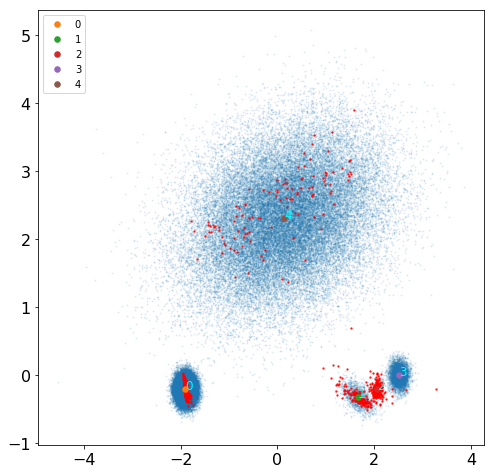

In [10]:
import pyro.distributions as dist
from pyro_extras import MixtureDistribution
from sklearn.decomposition import PCA

n_prior_samples = 100_000

with torch.no_grad():
    xi_posterior = fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc")).detach().cpu().numpy()
    
    fsd_xi_prior_locs = fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_prior_locs"))
    fsd_xi_prior_scales = pyro.param("fsd_xi_prior_scales")
    fsd_xi_prior_dist = model.get_fsd_xi_prior_dist(fsd_xi_prior_locs, fsd_xi_prior_scales)
    xi_prior = fsd_xi_prior_dist.sample((n_prior_samples,)).cpu().numpy()
    

pca = PCA(n_components=2)
xi_prior_pca_fit = pca.fit(xi_posterior)
xi_prior_pca = xi_prior_pca_fit.transform(xi_prior)
xi_posterior_pca = xi_prior_pca_fit.transform(xi_posterior)
xi_prior_locs_pca = xi_prior_pca_fit.transform(pyro.param("fsd_xi_prior_locs").detach().cpu().numpy())


fig = plt.figure(figsize=(8, 8))
plt.scatter(xi_prior_pca[:, 0], xi_prior_pca[:, 1], alpha=0.1, s=1)
plt.scatter(xi_posterior_pca[:, 0], xi_posterior_pca[:, 1], alpha=0.7, s=2, color='red')
for j in range(model.fsd_gmm_num_components):
    plt.scatter(xi_prior_locs_pca[j, 0], xi_prior_locs_pca[j, 1], s=30, marker='o', label=str(j))
    plt.text(xi_prior_locs_pca[j, 0], xi_prior_locs_pca[j, 1], str(j), color='cyan', size=12)
plt.legend()


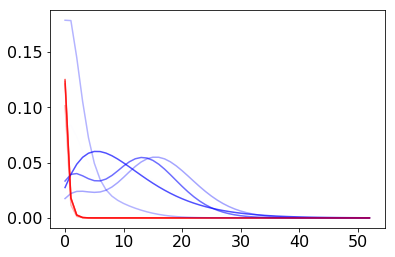

In [11]:
fig = plt.figure()

for fsd_gmm_comp_idx in range(5):
    fsd_xi = pyro.param("fsd_xi_prior_locs")[fsd_gmm_comp_idx, :]
    dist_lo, dist_hi = fsd_codec.get_fsd_components(fsd_codec.decode(fsd_xi), None)
    max_fs = sc_fingerprint_datastore.max_family_size + 1

    p_hi = dist_hi.log_prob(torch.arange(1, max_fs
                                        ).float().cuda()).detach().cpu().exp().numpy().flatten()
    p_lo = dist_lo.log_prob(torch.arange(1, max_fs).float().cuda()).detach().cpu().exp().numpy().flatten()
    plt.plot(p_hi, color='blue', alpha=np.sqrt(pyro.param("fsd_xi_prior_weights_map")[fsd_gmm_comp_idx].item()))
    plt.plot(p_lo, color='red', alpha=np.sqrt(pyro.param("fsd_xi_prior_weights_map")[fsd_gmm_comp_idx].item()))

## Save Model

In [ ]:
model_output_path = os.path.join(output_path, f"{dataset_name}_{sc_fingerprint_datastore.n_genes}_genes_marginalized.pyro")
pyro.get_param_store().save(model_output_path)

## Posterior Expression

In [142]:
from sampling import PosteriorImportanceSampler
from pyro_extras import get_log_prob_compl, logaddexp
from pyro.distributions.torch_distribution import TorchDistribution
from typing import Tuple, Callable

In [144]:
class PosteriorGeneExpressionSampler(object):
    
    def __init__(self,
                 sc_family_size_model: SingleCellFamilySizeModel,
                 n_particles: int,
                 device: torch.device,
                 dtype: torch.dtype,
                 drop_fingerprint_log_norm_factor: bool = False):
        self.sc_family_size_model = sc_family_size_model
        self.n_particles = n_particles
        self.device = device
        self.dtype = dtype
        self.drop_fingerprint_log_norm_factor = drop_fingerprint_log_norm_factor

    def generate_single_gene_minibatch_data(self,
                                            gene_index: int,
                                            i_cell_begin: int,
                                            i_cell_end: int) -> Dict[str, torch.Tensor]:
        """Generate model input tensors for a given gene index and the cell index range
        
        .. note: The generated minibatch has scale-factor set to 1.0 for all gene and cell sampling
            sites (because they are not necessary for our purposes here). As such, the minibatches
            produced by this method should not be used for training.
        """
        cell_index_array = np.arange(i_cell_begin, i_cell_end)
        gene_index_array = gene_index * np.ones_like(cell_index_array)
        cell_sampling_site_scale_factor_array = np.ones_like(cell_index_array)
        gene_sampling_site_scale_factor_array = np.ones_like(cell_index_array)
        
        return sc_fingerprint_datastore.generate_torch_minibatch_data(
            cell_index_array,
            gene_index_array,
            cell_sampling_site_scale_factor_array,
            gene_sampling_site_scale_factor_array,
            self.device,
            self.dtype)
    
    @torch.no_grad()
    def get_fsd_components_log_probs_full(self, minibatch_data: Dict[str, torch.Tensor]) \
        -> Tuple[TorchDistribution, TorchDistribution]:
        """Calculates log prob of family size distribution components (chimeric and real) over
        the full range of included family sizes, starting with 0 (unobserved molecules).
        """
        # vector of family size values
        max_family_size = minibatch_data['fingerprint_tensor'].shape[1]
        family_size_vector_full = torch.arange(0, max_family_size + 1, device=self.device).type(self.dtype)

        # get fsd components
        guide_trace = poutine.trace(self.sc_family_size_model.guide).get_trace(minibatch_data)
        fsd_params_dict = self.sc_family_size_model.fsd_codec.decode(guide_trace.nodes['fsd_xi']['value'])
        fsd_lo_dist, fsd_hi_dist = self.sc_family_size_model.fsd_codec.get_fsd_components(fsd_params_dict)

        log_prob_fsd_lo_full = fsd_lo_dist.log_prob(family_size_vector_full)
        log_prob_fsd_hi_full = fsd_hi_dist.log_prob(family_size_vector_full)

        return log_prob_fsd_lo_full, log_prob_fsd_hi_full
    
    @torch.no_grad()
    def _get_omega_prior_and_proposal_dists(self, minibatch_data: Dict[str, torch.Tensor]) \
        -> Tuple[TorchDistribution, TorchDistribution]:
        """Generates a decent distribution for importance-sampling of :math:`\omega` (the
        over-dispersion of :math:`\lambda^>`) in posterior expectation integrals.
        
        :returns: a tuple of (prior distribution, proposal distribution)
        """
        # generate the required quantities
        alpha_e_hi_minibatch = pyro.param("phi_e_hi")[minibatch_data['gene_index_tensor']].reciprocal()
        mu_e_hi_minibatch = pyro.param("mu_e_hi")[minibatch_data['gene_index_tensor']]
        logit_p_zero_e_hi_minibatch = pyro.param("logit_p_zero_e_hi")[minibatch_data['gene_index_tensor']]
        p_nnz_e_hi_minibatch = get_log_prob_compl(torch.nn.functional.logsigmoid(logit_p_zero_e_hi_minibatch)).exp()
        e_obs = minibatch_data['fingerprint_tensor'].sum(-1)
        
        # gamma concentration and rates
        prior_concentration = alpha_e_hi_minibatch
        prior_rate = alpha_e_hi_minibatch
        proposal_concentration = alpha_e_hi_minibatch + e_obs
        proposal_rate = alpha_e_hi_minibatch + mu_e_hi_minibatch * p_nnz_e_hi_minibatch
        
        return (dist.Gamma(prior_concentration, prior_rate),
                dist.Gamma(proposal_concentration, proposal_rate))
    
    def _get_log_like_and_objective_functions(self, minibatch_data: Dict[str, torch.Tensor]) \
        -> Tuple[Callable[[torch.Tensor], torch.Tensor],
                 Callable[[torch.Tensor], torch.Tensor]]:
        """TBW.
        """
        fingerprint_tensor_nr = minibatch_data['fingerprint_tensor']
        log_fingerprint_tensor_nr = fingerprint_tensor_nr.log()
        
        (log_prob_fsd_lo_full_nr,
         log_prob_fsd_hi_full_nr) = self.get_fsd_components_log_probs_full(minibatch_data)
        log_prob_fsd_lo_obs_nr = log_prob_fsd_lo_full_nr[..., 1:]
        log_prob_fsd_hi_obs_nr = log_prob_fsd_hi_full_nr[..., 1:]
        total_p_obs_lo_n = log_prob_fsd_lo_obs_nr.exp().sum(-1)
        total_p_obs_hi_n = log_prob_fsd_hi_obs_nr.exp().sum(-1)
        
        mu_e_lo_n = pyro.param("mu_e_lo")[minibatch_data['gene_index_tensor']]
        mu_e_hi_n = pyro.param("mu_e_hi")[minibatch_data['gene_index_tensor']]
        
        total_obs_rate_lo_n = mu_e_lo_n * total_p_obs_lo_n
        total_obs_rate_hi_n = mu_e_lo_n * total_p_obs_hi_n
        
        log_rate_e_lo_nr = mu_e_lo_n.log().unsqueeze(-1) + log_prob_fsd_lo_obs_nr
        log_rate_e_hi_nr = mu_e_hi_n.log().unsqueeze(-1) + log_prob_fsd_hi_obs_nr
        
        if self.drop_fingerprint_log_norm_factor:
            fingerprint_log_norm_factor_n = torch.ones_like(total_obs_rate_lo_n)
        else:
            fingerprint_log_norm_factor_n = (fingerprint_tensor_nr + 1).lgamma().sum(-1)
        
        def _fingerprint_log_like_function(omega_mn: torch.Tensor) -> torch.Tensor:
            log_rate_combined_mnr = logaddexp(
                log_rate_e_lo_nr,
                log_rate_e_hi_nr + omega_mn.log().unsqueeze(-1))
            return (
                (fingerprint_tensor_nr * log_rate_combined_mnr).sum(-1)
                - (total_obs_rate_lo_n + total_obs_rate_hi_n * omega_mn)
                - fingerprint_log_norm_factor_n)
        
        def _log_e_hi_function(omega_mn: torch.Tensor) -> torch.Tensor:
            log_rate_e_hi_mnr = log_rate_e_hi_nr + omega_mn.log().unsqueeze(-1)
            log_rate_combined_mnr = logaddexp(log_rate_e_lo_nr, log_rate_e_hi_mnr)
            log_e_hi_obs_mn = torch.logsumexp(
                log_fingerprint_tensor_nr
                + log_rate_e_hi_mnr
                - log_rate_combined_mnr, -1)
            log_e_hi_unobs_mn = mu_e_hi_n + omega_mn + log_prob_fsd_hi_full_nr[..., 0]
            return logaddexp(log_e_hi_unobs_mn, log_e_hi_obs_mn)
        
        return _fingerprint_log_like_function, _log_e_hi_function

In [145]:
posterior_sampler = PosteriorGeneExpressionSampler(model, 5, device, dtype)
shard_data = posterior_sampler.generate_single_gene_minibatch_data(0, 0, 100)

In [150]:
prior_dist, proposal_dist = posterior_sampler._get_omega_prior_and_proposal_dists(shard_data)
log_like_function, log_objective_function = posterior_sampler._get_log_like_and_objective_functions(shard_data)



KeyError: 'mu_e_lo'

In [ ]:
samples_mn = proposal_dist.sample(torch.Size([5]))